In [284]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.ndimage.morphology import binary_erosion


# ESTIMATION

In [7]:
# Data from Yahoo, US 10y treasury yield
df = pd.read_csv('^TNX.csv', parse_dates=['Date']).set_index('Date')
df.head(2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1962-01-02,4.06,4.06,4.06,4.06,4.06,0.0
1962-01-03,4.03,4.03,4.03,4.03,4.03,0.0


In [19]:
# take the adj close as the data to work with. 
# as this is a bond yield, it is actually the same to Close
ds = df['Adj Close']
# drop nas
ds.dropna(inplace=True)
print("# of NAs " + str(ds.isna().sum()))

# of NAs 0


In [15]:
def ar1p_oup(alpha, beta, sigma):
    theta = 1 - beta
    mu = alpha / theta
    sigma = sigma
    return theta, mu, sigma

In [66]:
# regression (essentially, MLE) estimation
# returns alpha, beta anㅇ sigma
def estimate_reg(x: np.array):

    # in matrix form (I could have call an existing module... but..)
    Y = x[1:].reshape([-1,1])
    X = np.array([np.ones(x.size-1), x[:-1]]).T # add constant

    ab = np.linalg.solve(np.dot(X.T,X), np.dot(X.T, Y))
    r = Y - np.dot(X, ab)
    sig = np.std(r)
    return ab[0,0], ab[1,0], sig

def estimate_mm(x: np.array):

    mu = np.mean(x)
    v = np.var(x)
    vd = np.var(np.diff(x))

    beta = 1 - vd/(2.0*v)
    alpha = (1.0-beta) * mu
    sigma = np.sqrt(v) * np.sqrt(1.0-beta**2)

    return alpha, beta, sigma

In [245]:
win_size = 1250
reg_estim = []
mm_estim = []
for ds_w in ds.rolling(window=win_size):
    if ds_w.size < win_size: # if not enough data, skip
        continue
    res = {"start": ds_w.index[0], "end": ds_w.index[-1]}
    res['alpha'], res['beta'], res['sigma'] = estimate_reg(ds_w.to_numpy())
    reg_estim.append(res)

    res = {"start": ds_w.index[0], "end": ds_w.index[-1]}
    res['alpha'], res['beta'], res['sigma'] = estimate_mm(ds_w.to_numpy())
    mm_estim.append(res)

df_reg = pd.DataFrame(reg_estim)
df_mm = pd.DataFrame(mm_estim)

In [246]:
to_ou_param = lambda df: pd.DataFrame(
    data=np.array(ar1p_oup(df['alpha'].to_numpy(), df['beta'].to_numpy(), df['sigma'].to_numpy())).T, 
    columns = ["theta", "mu", "sigma"], index = df["end"]).reset_index()

df_reg_ou = to_ou_param(df_reg)
df_mm_ou = to_ou_param(df_mm)


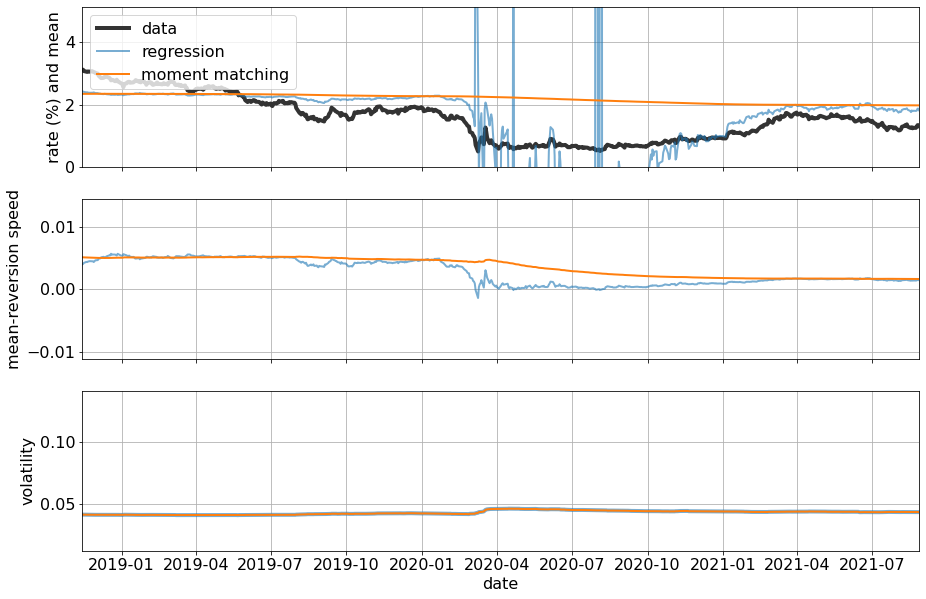

In [294]:
t_end = df_reg["end"]
alpv = 0.6

x_range = [ds.index[-900], ds.index[-200]]
#x_range = [ds.index[0], ds.index[-1]] # for full picture
ds_p = ds.loc[x_range[0]:x_range[1]]

plt.rcParams['font.size'] = '16'
plt.figure(figsize=(15, 10))
ax1 = plt.subplot(3,1,1)
plt.plot(ds_p.index, ds_p, c=0.2*np.ones(3), lw=4, label='data')
plt.plot(t_end, df_reg_ou["mu"], alpha=alpv, lw=2, label='regression')
plt.plot(t_end, df_mm_ou["mu"], lw=2, label='moment matching')
plt.ylim([np.min(ds_p)-0.5, np.max(ds_p)+2])
plt.xlim(x_range)
plt.ylabel('rate (%) and mean')
plt.legend(loc=2)
plt.tick_params(labelbottom=False)
plt.grid()

ax2=plt.subplot(3,1,2, sharex=ax1)
plt.plot(t_end, df_reg_ou["theta"], lw=2, alpha=alpv)
plt.plot(t_end, df_mm_ou["theta"], lw=2)
plt.tick_params(labelbottom=False)
plt.ylabel('mean-reversion speed')
plt.grid()

#plt.pcolor(t_end, [np.min(z), np.max(z)], (np.maximum(0.00, np.minimum(z, 0.02))), zorder=-10, vmin=-0.002, vmax=0.005, cmap= plt.get_cmap('Greys_r'))

plt.subplot(3,1,3, sharex=ax1)

plt.plot(t_end, df_reg_ou["sigma"], lw=4, alpha=alpv)
plt.plot(t_end, df_mm_ou["sigma"], lw=2)
plt.xlabel('date')
plt.ylabel('volatility')
plt.grid()
#plt.savefig('ou-estim-zm.png')
plt.show()


# Simuation

In [265]:
df_mm_ou.iloc[-1], ds[-1]

(end      2022-06-13 00:00:00
 theta               0.001895
 mu                  1.935929
 sigma               0.047497
 Name: 13873, dtype: object,
 3.366)

In [297]:
T = 1000
M = 5000
ds_e = df_mm_ou.iloc[-1]
theta, mu, sigma = ds_e["theta"], ds_e["mu"], ds_e["sigma"]
x0 = ds[-1]

x_t = np.ones(M) * x0
Xp = [x_t]
for t in range(T):
    x_t = x_t + theta*(mu - x_t) + sigma * np.random.standard_normal(M)
    Xp.append(x_t)
Xp = np.array(Xp)

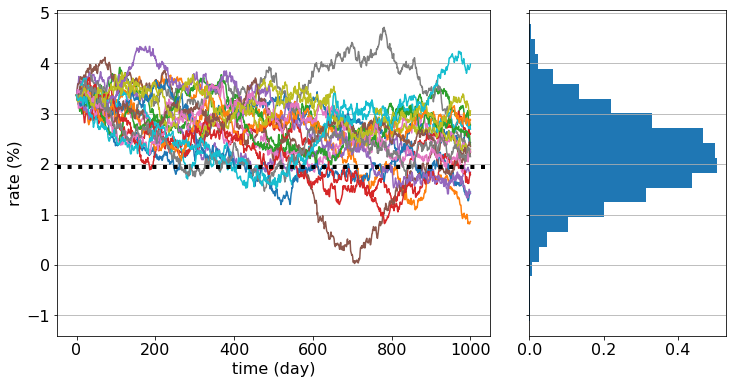

In [307]:
tp = np.arange(0, T+1)
fig = plt.figure(figsize=(12,6))
gs = gridspec.GridSpec(3,3)
ax_sim = plt.subplot(gs[:, :2])
ax_dist = plt.subplot(gs[:, 2], sharey=ax_sim)
plt.sca(ax_sim)
plt.plot(tp, Xp[:,::250])
plt.axhline(mu, c='k', ls=':', lw=4)
plt.xlabel('time (day)'), plt.ylabel('rate (%)')
plt.grid(axis='y')
plt.sca(ax_dist)
plt.hist(Xp[-1], bins=20, density=True, align='mid', orientation='horizontal')
plt.tick_params(labelleft=False)
plt.grid(axis='y')
plt.savefig('ou-sim.png')
plt.show()

3.366